In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from surprise import Reader, Dataset, SVD
from surprise import KNNBasic
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split
from surprise import accuracy

In [6]:
#load the dataset
df = pd.read_csv("/Users/susmitapoudel/downloads/spotify_dataset.csv", on_bad_lines='skip')
df.head()

,user_id,"""artistname""","""trackname""","""playlistname"""
0,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,(The Angels Wanna Wear My) Red Shoes,HARD ROCK 2010
1,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,"(What's So Funny 'Bout) Peace, Love And Unders...",HARD ROCK 2010
2,9cc0cfd4d7d7885102480dd99e7a90d6,Tiffany Page,7 Years Too Late,HARD ROCK 2010
3,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello & The Attractions,Accidents Will Happen,HARD ROCK 2010
4,9cc0cfd4d7d7885102480dd99e7a90d6,Elvis Costello,Alison,HARD ROCK 2010


In [8]:
#get information about row and col

row_count = df.shape[0]
col_count = df.shape[1]
print("Total Rows: " , row_count)
print("Total Columns: " , col_count)
print(df.columns)

Total Rows:  12891680
Total Columns:  4
Index(['user_id', ' "artistname"', ' "trackname"', ' "playlistname"'], dtype='object')


In [9]:
# dropping rows with null values
music_df = df.dropna()
print("Updated rows", music_df.shape[0])
print(music_df.isnull().sum())

Updated rows 12856831
user_id            0
 "artistname"      0
 "trackname"       0
 "playlistname"    0
dtype: int64


In [10]:
#change column names to more meaningful names
print("Before", music_df.columns.tolist())
music_df.columns = music_df.columns.str.strip().str.replace('"', '').str.replace("'", '')
music_df.rename(columns={'artistname': 'artist_name'}, inplace=True)
music_df.rename(columns={'trackname': 'track_name'}, inplace=True)
print("After", music_df.columns.tolist())

Before ['user_id', ' "artistname"', ' "trackname"', ' "playlistname"']
After ['user_id', 'artist_name', 'track_name', 'playlistname']


/var/folders/dn/rdf6dkk51ps__wbzt2xk4d100000gn/T/ipykernel_40874/47056292.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music_df.rename(columns={'artistname': 'artist_name'}, inplace=True)
/var/folders/dn/rdf6dkk51ps__wbzt2xk4d100000gn/T/ipykernel_40874/47056292.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  music_df.rename(columns={'trackname': 'track_name'}, inplace=True)


In [11]:
print("Unique users:", music_df['user_id'].nunique())
print("Unique playlist:", music_df['playlistname'].nunique())
print("Unique artist count",music_df['artist_name'].nunique())
print("Unique songs count",music_df['track_name'].nunique())

Unique users: 15914
Unique playlist: 157320
Unique artist count 289602
Unique songs count 2004520


In [12]:
#cleaning the columns to make it more uniform
def clean_columns(df):
    for col in df.select_dtypes(include=['object']):  # Select string columns
        df[col] = df[col].str.strip().str.lower()  # Remove leading/trailing spaces
        df[col] = df[col].str.replace('[^A-Za-z0-9 ]+', '', regex=True)  # Remove unwanted characters
    return df

df_cleaned = clean_columns(music_df)
df_cleaned.dropna()
print(df_cleaned)

/var/folders/dn/rdf6dkk51ps__wbzt2xk4d100000gn/T/ipykernel_40874/4039868250.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.strip().str.lower()  # Remove leading/trailing spaces
/var/folders/dn/rdf6dkk51ps__wbzt2xk4d100000gn/T/ipykernel_40874/4039868250.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col] = df[col].str.replace('[^A-Za-z0-9 ]+', '', regex=True)  # Remove unwanted characters


                                   user_id                      artist_name  \
0         9cc0cfd4d7d7885102480dd99e7a90d6                   elvis costello   
1         9cc0cfd4d7d7885102480dd99e7a90d6  elvis costello  the attractions   
2         9cc0cfd4d7d7885102480dd99e7a90d6                     tiffany page   
3         9cc0cfd4d7d7885102480dd99e7a90d6  elvis costello  the attractions   
4         9cc0cfd4d7d7885102480dd99e7a90d6                   elvis costello   
...                                    ...                              ...   
12891675  2302bf9c64dc63d88a750215ed187f2c                        mtley cre   
12891676  2302bf9c64dc63d88a750215ed187f2c                      john lennon   
12891677  2302bf9c64dc63d88a750215ed187f2c                        tom petty   
12891678  2302bf9c64dc63d88a750215ed187f2c                        tom petty   
12891679  2302bf9c64dc63d88a750215ed187f2c                         skid row   

                                                tra

In [14]:
#adding a column "unique songs" that combines "artist_name" and "track_name" to ensure uniquessness
df_cleaned['unique_songs'] = df_cleaned['artist_name'].str.replace(" ", '') + "-" + df_cleaned['track_name'].str.replace(" ", '')
df_cleaned = df_cleaned[df_cleaned['unique_songs'] != '-']
df_cleaned.head()

/var/folders/dn/rdf6dkk51ps__wbzt2xk4d100000gn/T/ipykernel_40874/3423458122.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['unique_songs'] = df_cleaned['artist_name'].str.replace(" ", '') + "-" + df_cleaned['track_name'].str.replace(" ", '')


,user_id,artist_name,track_name,playlistname,unique_songs
0,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,the angels wanna wear my red shoes,hard rock 2010,elviscostello-theangelswannawearmyredshoes
1,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello the attractions,whats so funny bout peace love and understanding,hard rock 2010,elviscostellotheattractions-whatssofunnyboutpe...
2,9cc0cfd4d7d7885102480dd99e7a90d6,tiffany page,7 years too late,hard rock 2010,tiffanypage-7yearstoolate
3,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello the attractions,accidents will happen,hard rock 2010,elviscostellotheattractions-accidentswillhappen
4,9cc0cfd4d7d7885102480dd99e7a90d6,elvis costello,alison,hard rock 2010,elviscostello-alison


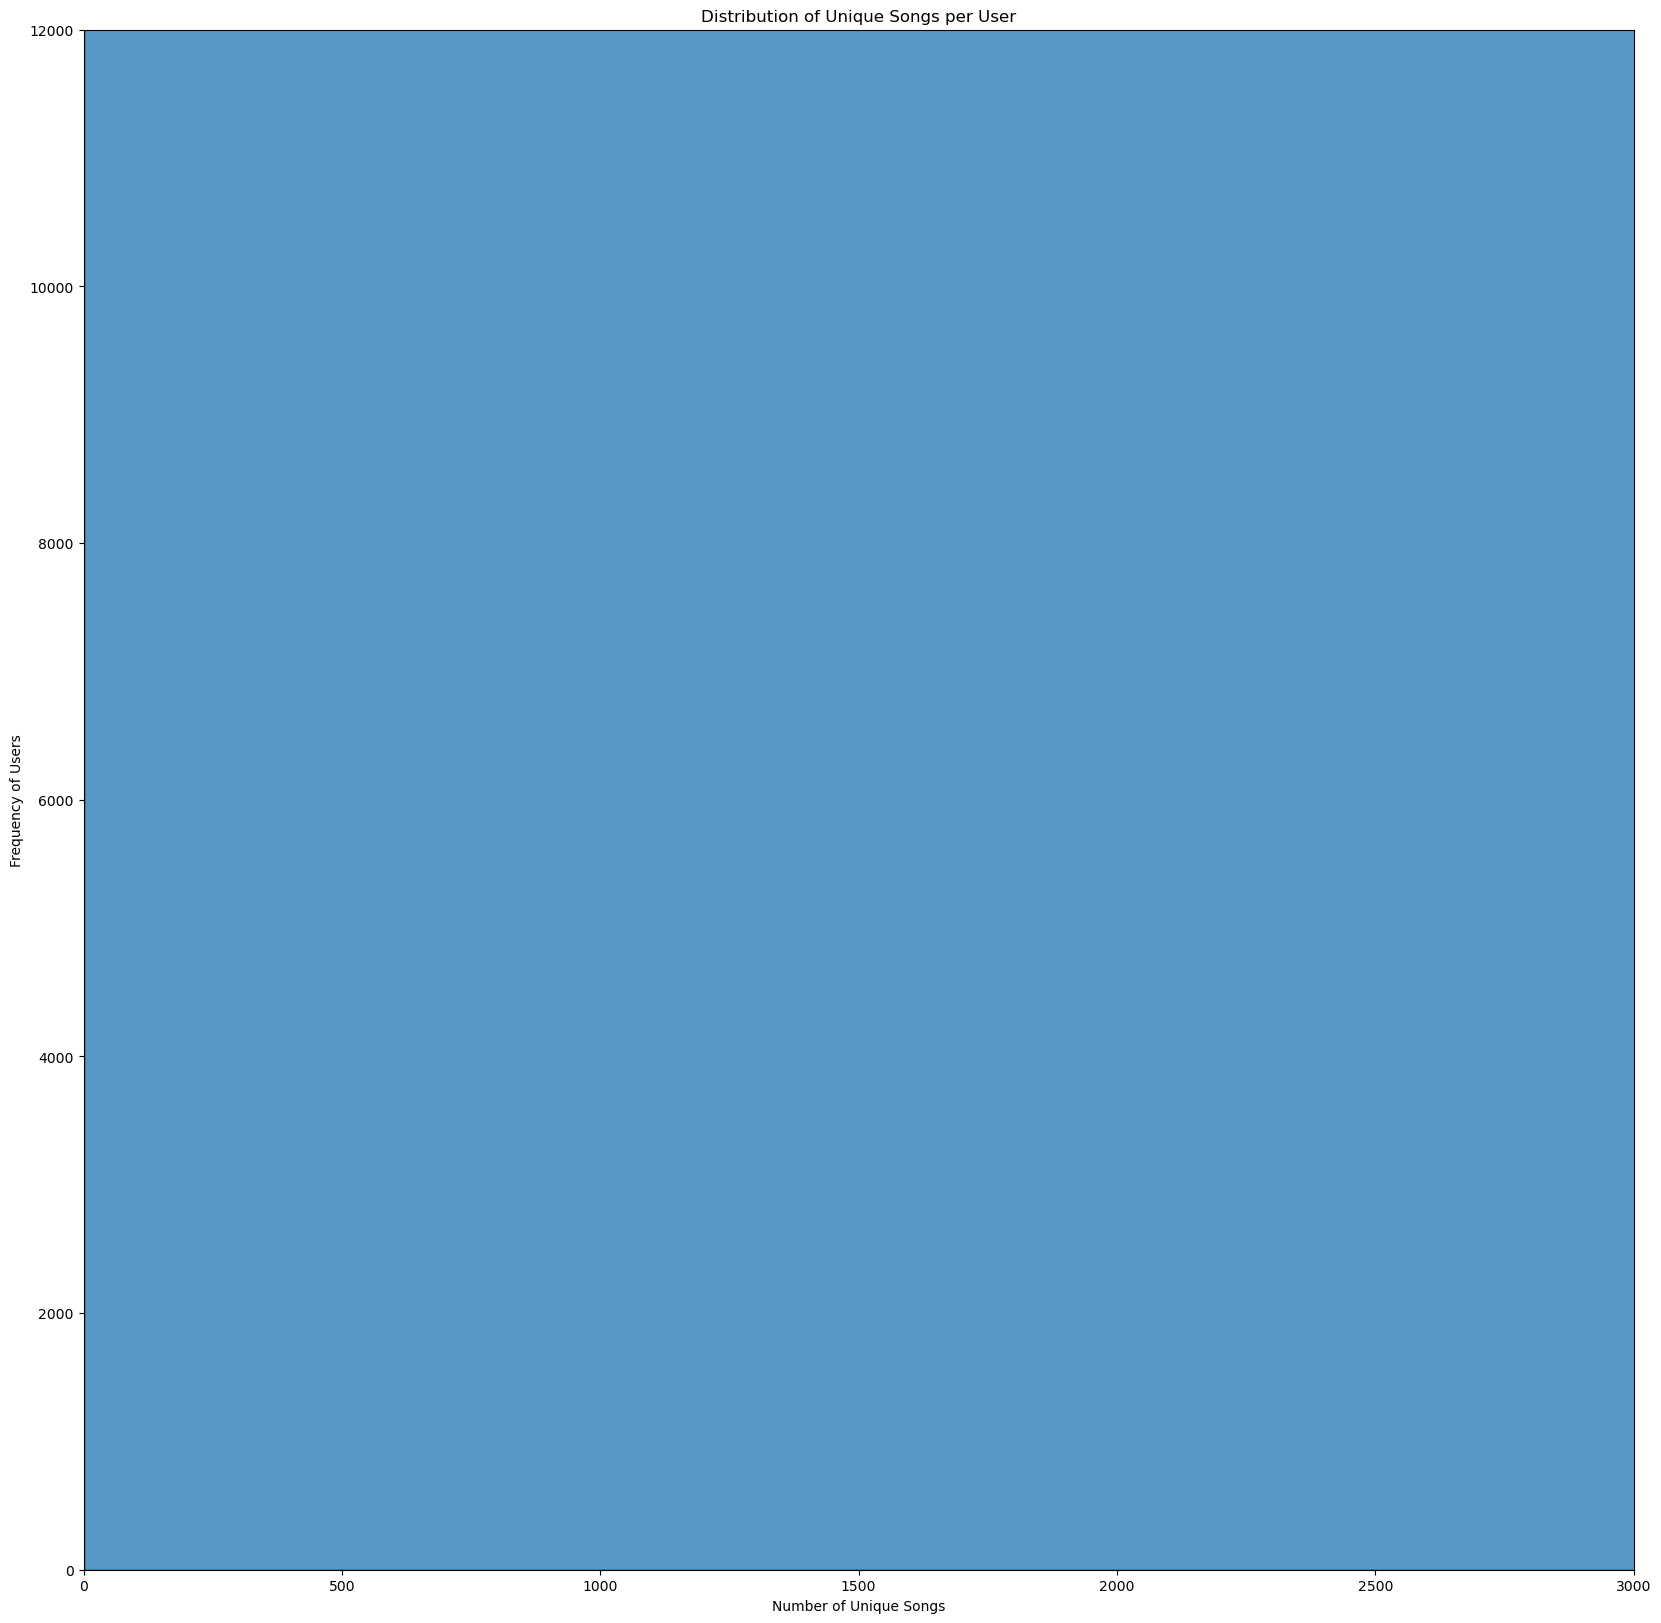

In [15]:
# Count the number of unique songs per user
song_counts = df_cleaned.groupby('user_id')['unique_songs'].nunique().reset_index()
song_counts.columns = ['user_id', 'unique_song_count']

# Plot the distribution using seaborn
plt.figure(figsize=(20, 20))
sns.histplot(song_counts['unique_song_count'], bins=10, kde=False)
plt.xlim(0,3000)
plt.ylim(0,12000)
plt.title('Distribution of Unique Songs per User')
plt.xlabel('Number of Unique Songs')
plt.ylabel('Frequency of Users')
plt.show()

In [43]:

user_song_count = df_cleaned.groupby('user_id')['unique_songs'].nunique()
print("User",len(user_song_count))
users_with_40_or_more_songs = user_song_count[user_song_count >= 40].index
print("User with 40 or more songs", len(users_with_40_or_more_songs))
#print(df_cleaned.columns)
song_user_count = music_df.groupby('unique_songs')['user_id'].nunique()

filtered_df = df_cleaned[df_cleaned['user_id'].isin(users_with_40_or_more_songs)]
# Filter songs that have at least 100 unique users
songs_with_100_or_more_users = song_user_count[song_user_count >= 100].index
print("Unique song count",len(songs_with_100_or_more_users))
filtered_df = filtered_df[filtered_df['unique_songs'].isin(songs_with_100_or_more_users)]
print(filtered_df.shape)


print("Unique users:", filtered_df['user_id'].nunique())
print("Unique playlist:", filtered_df['playlistname'].nunique())
print("Unique artist count",filtered_df['track_name'].nunique())
print("Unique song-artist count",filtered_df['unique_songs'].nunique())

User 15913
User with 40 or more songs 13339
Unique song count 11054
(2850680, 5)
Unique users: 13147
Unique playlist: 73145
Unique artist count 11177
Unique song-artist count 11053


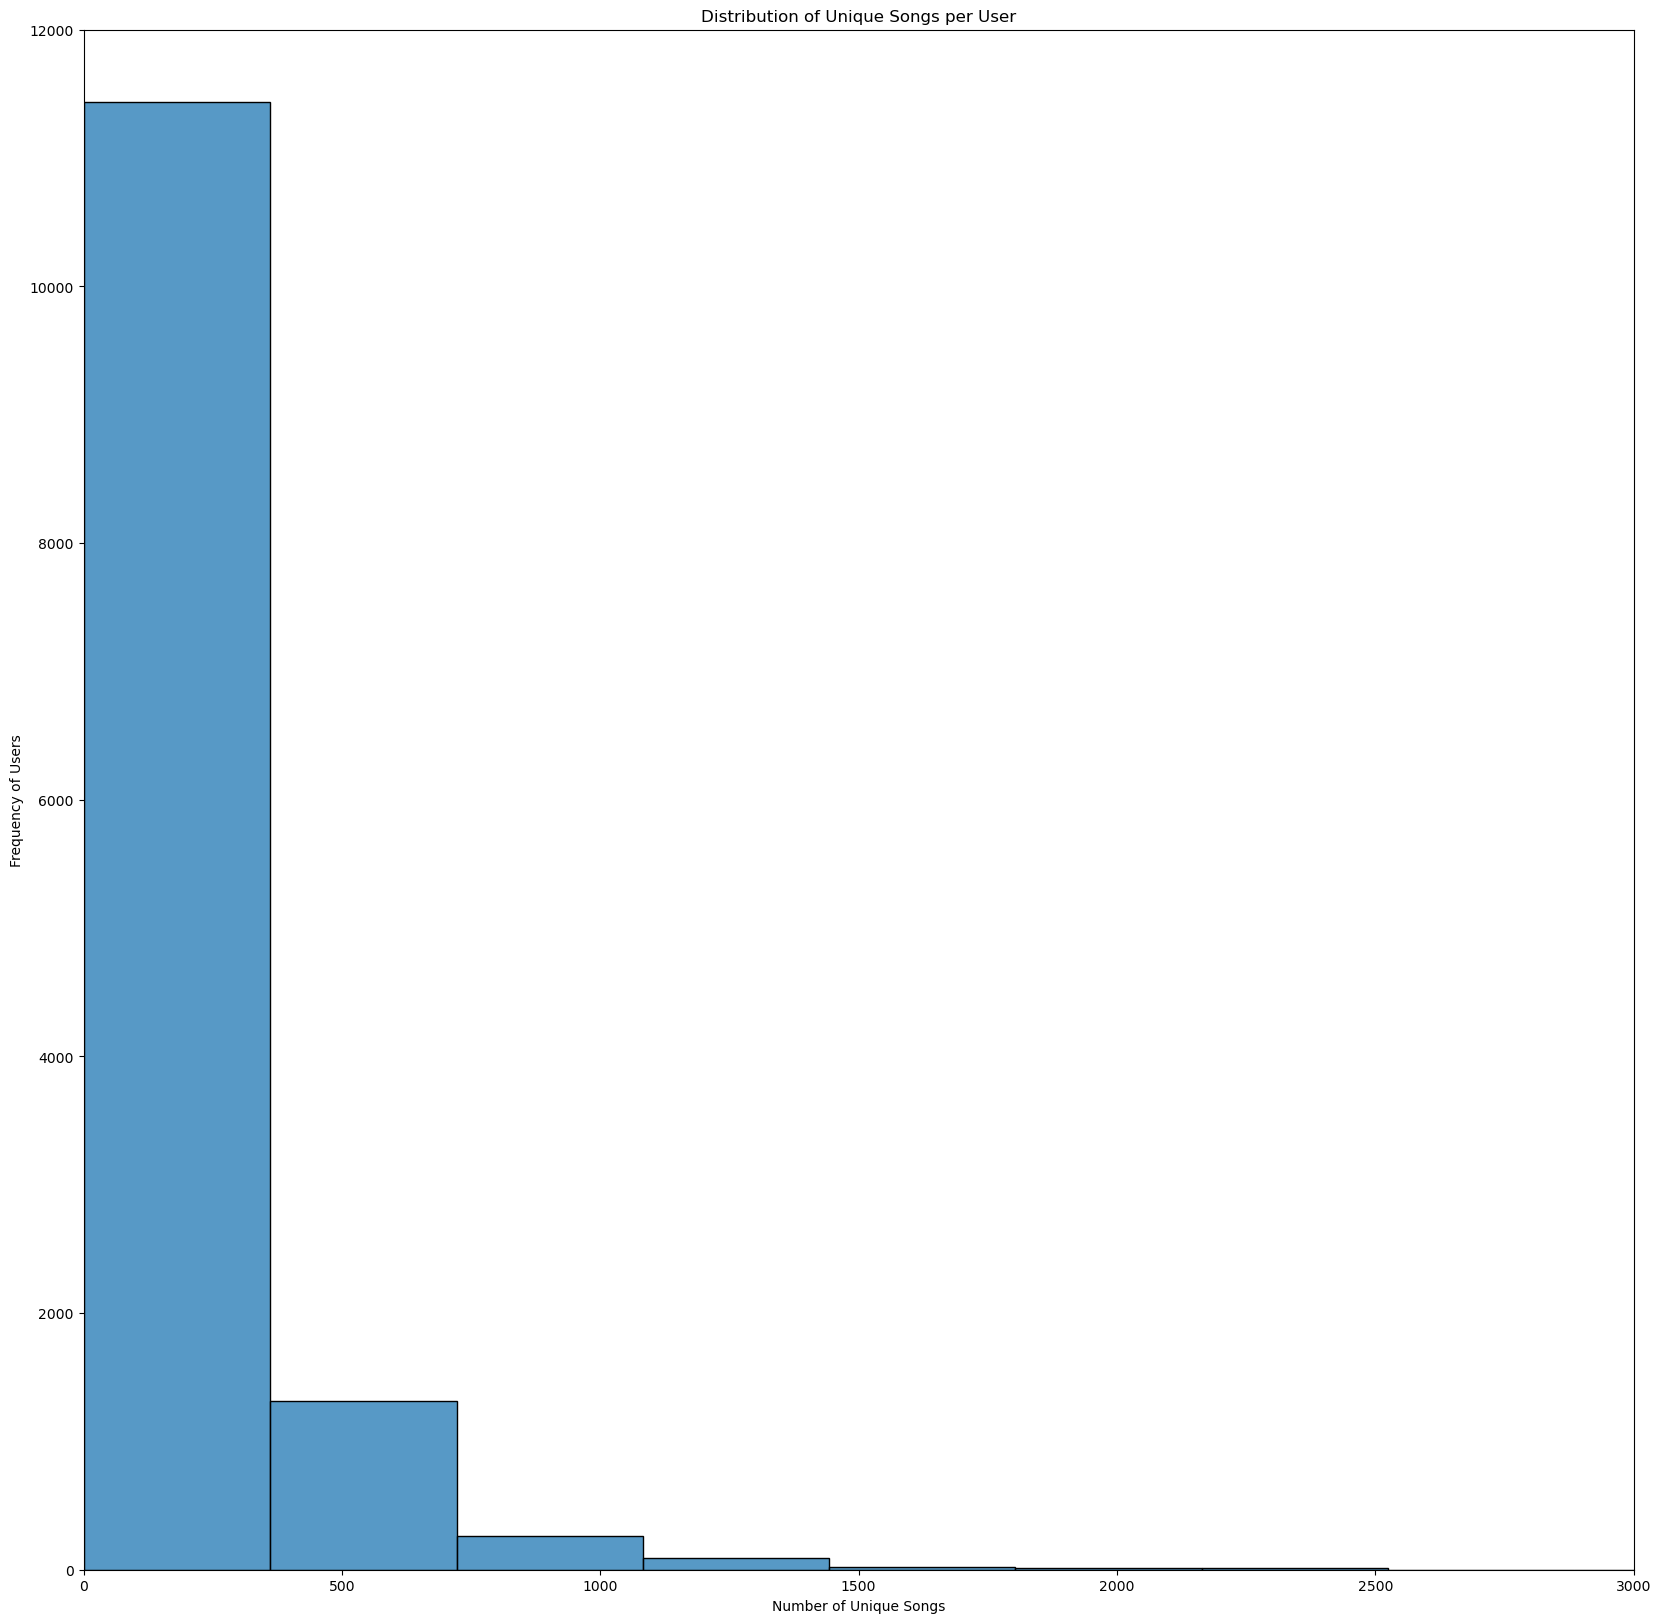

In [44]:
# Count the number of unique songs per user
song_counts = filtered_df.groupby('user_id')['unique_songs'].nunique().reset_index()
song_counts.columns = ['user_id', 'unique_song_count']

# Plot the distribution using seaborn
plt.figure(figsize=(20, 20))
sns.histplot(song_counts['unique_song_count'], bins=10, kde=False)
plt.xlim(0,3000)
plt.ylim(0,12000)
plt.title('Distribution of Unique Songs per User')
plt.xlabel('Number of Unique Songs')
plt.ylabel('Frequency of Users')
plt.show()

In [45]:
ratings = pd.DataFrame(filtered_df)
interaction_matrix = ratings.pivot_table(index='user_id', columns='unique_songs', aggfunc='size', fill_value=0)

# Convert to binary (1 if count > 0, else 0)
#interaction_matrix = (interaction_matrix > 0).astype(int)
print(interaction_matrix.shape)

(13147, 11053)


In [46]:
#include unique_song-user combination with interaction is 1
df_long = interaction_matrix.stack().reset_index(name='playlist')
df_long = df_long[df_long['playlist'] == 1]
print(df_long)

                                    user_id  \
273        00055176fea33f6e027cd3302289378b   
626        00055176fea33f6e027cd3302289378b   
825        00055176fea33f6e027cd3302289378b   
1070       00055176fea33f6e027cd3302289378b   
1080       00055176fea33f6e027cd3302289378b   
...                                     ...   
145313257  fff77dadf8528083c920b9c018847e8b   
145313355  fff77dadf8528083c920b9c018847e8b   
145313485  fff77dadf8528083c920b9c018847e8b   
145313519  fff77dadf8528083c920b9c018847e8b   
145313681  fff77dadf8528083c920b9c018847e8b   

                                 unique_songs  playlist  
273             alltimelow-dearmariacountmein         1  
626        avrillavigne-herestonevergrowingup         1  
825                             beckyg-shower         1  
1070                   blink182-aftermidnight         1  
1080                       blink182-firstdate         1  
...                                       ...       ...  
145313257       twodoorcinema

In [48]:
df_sampled = df_long.sample(frac=0.3, random_state=42)

# Check the size of the new sampled dataset
print(df_sampled)
#rmse = 0.5

                                    user_id  \
43077293   4aebcca431d08ae1b50544d96d90ba1a   
53605775   5cda2fef9394d95de7444ebec42b5341   
79369040   8b07786b616698aa0112ffd92b3ae35a   
133756611  ebeca1badbd7f968878f4aa94b3d274e   
15204792   1aaa6db809b4d05bb7094778b76855dd   
...                                     ...   
18712072   20350023c94899ce25cd1a86ea385853   
78538548   898b985bbd7086df4b2c7d1f0e59f7ee   
53803230   5d2cd4fb46fe9dc4a1c4a2dff0fcac1c   
143745279  fcee1aa12d81340ae843cd2fa10378e0   
20587332   237c0b71c3e7f8d47b58a094c90ab49d   

                                    unique_songs  playlist  
43077293               glenhansard-fallingslowly         0  
53605775              theojays-fortheloveofmoney         0  
79369040                         shakira-sitevas         0  
133756611                 jackwhite-justonedrink         0  
15204792                  nickiminaj-moment4life         0  
...                                          ...       ...  
18712072

In [47]:
# only positive interaction 
reader = Reader(rating_scale=(0, 1))
dataset = Dataset.load_from_df(df_long[['user_id', 'unique_songs', 'playlist']], reader)

In [48]:

algo = SVD()
cross_validate(algo, dataset, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.0279  0.0279  0.0277  0.0278  0.0277  0.0278  0.0001  
MAE (testset)     0.0138  0.0138  0.0138  0.0138  0.0138  0.0138  0.0000  
Fit time          12.54   12.68   13.06   12.90   12.97   12.83   0.19    
Test time         1.90    1.88    1.40    1.35    1.34    1.58    0.26    


{'test_rmse': array([0.02786718, 0.02789457, 0.02774988, 0.02775885, 0.02771653]),
 'test_mae': array([0.01383122, 0.01382574, 0.01375852, 0.01379292, 0.01376093]),
 'fit_time': (12.542972087860107,
  12.682839155197144,
  13.061156272888184,
  12.903613328933716,
  12.968540906906128),
 'test_time': (1.8972079753875732,
  1.8789870738983154,
  1.4031507968902588,
  1.3544549942016602,
  1.3447489738464355)}

In [49]:
trainset, testset = train_test_split(dataset, test_size=0.25)

In [50]:
model = SVD()  # Use the Singular Value Decomposition algorithm
model.fit(trainset)

In [51]:
predictions = model.test(testset)

In [52]:
rmse = accuracy.rmse(predictions)
print(f'RMSE: {rmse}')

RMSE: 0.0291
RMSE: 0.029081184893853897


In [53]:
def predict_user_interactions(user_id):
    """
    Given a user_id, predict the interaction scores for all songs for that user.
    
    :param user_id: ID of the user (integer)
    :return: A list of song ids and their predicted interaction scores for the user
    """
    user_playlist = filtered_df[filtered_df['user_id'] == user_id]['unique_songs'].unique()
    # Get a list of all unique songs 
    unique_song = filtered_df['unique_songs'].unique()
    songs_to_predict = [song for song in unique_song if song not in user_playlist]
    # Predict interaction scores for each song for the user
    predictions = []
    for song in songs_to_predict:
        prediction = model.predict(user_id, song)
        predictions.append((song, prediction.est))
    
    # Sort the songs by predicted interaction score (highest first)
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    return predictions[:5]

In [55]:
predicted_songs = predict_user_interactions('00055176fea33f6e027cd3302289378b')
print(predicted_songs)


[('elviscostello-alison', 1), ('crowdedhouse-fallatyourfeet', 1), ('joshuaradin-idratherbewithyouradioedit', 1), ('paulmccartney-liveandletdie', 1), ('crowdedhouse-weatherwithyou', 1)]


In [56]:
predict_user_interactions('fff77dadf8528083c920b9c018847e8b')

[('elviscostello-alison', 1),
 ('crowdedhouse-fallatyourfeet', 1),
 ('paulmccartney-liveandletdie', 1),
 ('joshuaradin-onlyyou', 1),
 ('crowdedhouse-weatherwithyou', 1)]